In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### Hyperparameters

In [56]:
#number of epochs
max_epochs = 6
#batch_size for training
batch_size_train = 16
# batch_size for testing
batch_size_test = 256

### Data Preparation

In [4]:
#transform to resize to 32 * 32 to be compatible with LeNet and to normalize it 
transform = transforms.Compose(
    [torchvision.transforms.Resize(32),
     transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5,), (0.5,))]
    )
train_data = datasets.MNIST("data", train=True, transform=transform, download=True)
test_data = datasets.MNIST("content", train=False, transform=transform, download=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting content/MNIST/raw/train-images-idx3-ubyte.gz to content/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting content/MNIST/raw/train-labels-idx1-ubyte.gz to content/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting content/MNIST/raw/t10k-images-idx3-ubyte.gz to content/MNIST/raw




Extracting content/MNIST/raw/t10k-labels-idx1-ubyte.gz to content/MNIST/raw

Processing...
Done!


### Visualizing Data

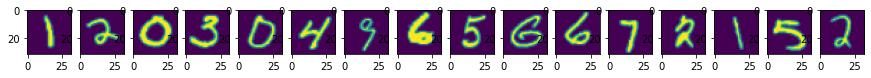

tensor([1, 2, 0, 3, 0, 4, 9, 6, 5, 6, 6, 7, 2, 1, 5, 2])


In [57]:
def imshow(imgs):
  fig = plt.figure(figsize=(15,15))
  for i, img in enumerate(imgs): 
    fig.add_subplot(1, len(imgs), i+1)
    img = img/2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.squeeze(np.transpose(npimg, (1, 2, 0)), 2))
  plt.show()

train_loader = torch.utils.data.DataLoader(train_data, batch_size=16,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=256, shuffle=True)      
for img, labels in train_loader: 
  imshow(img)
  print(labels)
  break


### Defining a Neural Network (LeNet)

In [58]:
class Net(nn.Module): 
  def __init__(self): 
    super().__init__()
    self.conv1 = nn.Conv2d(1, 6, 5)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.pool = nn.MaxPool2d((2, 2))
    # an affine operation Wx + b
    self.fc1 = nn.Linear(16 * 5 * 5, 120) # 5 * 5 image dimensions, 120 means its multiplied in Wx + b where w E R^120*400
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x): 
    x = self.pool(F.relu(self.conv1(x)))                   
    x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x
net = Net()
net.to(device) #send to cpu or cuda enabled gpu
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
critereon = nn.CrossEntropyLoss()
print(net)


Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### Training Network

In [59]:
running_loss = 0.0
for epoch in range(max_epochs): 
  for i, data in enumerate(train_loader, 0): 
    inputs, labels = data[0].to(device), data[1].to(device)
    optimizer.zero_grad()

    # forward then optimize
    out = net(inputs)
    loss = critereon(out, labels)
    loss.backward()
    optimizer.step()

    # statistics
    running_loss += loss.item()
    if (i+1) % 2000 == 0 : 
      print(f'{(epoch + 1, i + 1)} loss: {(running_loss / 2000):.2f}')
      running_loss = 0.0
print("Finished training")

(1, 2000) loss: 1.07
(2, 2000) loss: 0.23
(3, 2000) loss: 0.13
(4, 2000) loss: 0.10
(5, 2000) loss: 0.08
(6, 2000) loss: 0.07
Finished training


In [60]:
PATH = './mnist_net.pth'
torch.save(net.state_dict(), PATH)

### Testing Trained Model

#### Testing on single mini-batch

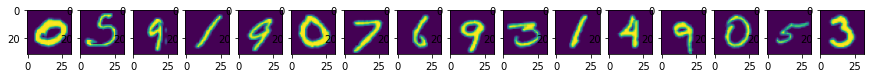

Groundtruth: tensor([0, 5, 9, 1, 9, 0, 7, 6, 9, 3, 1, 4, 9, 0, 5, 3])
Predicted: tensor([0, 5, 9, 1, 9, 0, 7, 6, 9, 3, 1, 4, 9, 0, 5, 3])
Accuracy on 16 images: 100.00 %


In [67]:
test_input = iter(test_loader).next()
imgs, labels = test_input[0].to(device), test_input[1].to(device)
imshow(imgs[:16])
print("Groundtruth:", labels[:16])
#instantiate new Net
net = Net()
net.to(device)
net.load_state_dict(torch.load(PATH)) #Load trained weights
out = net(imgs[:16])
_, predicted = torch.max(out, 1) # returns (max_value, index_max_value)
print("Predicted:", predicted)
print("Accuracy on 16 images:", f'{(float(sum(labels[:16] == predicted))/16 *100):.2f} %')

#### Testing on entire test dataset

In [68]:
#instantiating net 
net = Net()
net.to(device)
net.load_state_dict(torch.load(PATH)) # load trained weights
correct_pred = {classn : 0 for classn in range(10)}
total_pred = {classn : 0 for classn in range(10)}
correct = 0
total = 0
for i, data in enumerate(test_loader): 
  imgs, labels = data[0].to(device), data[1].to(device)
  total+=len(imgs)
  out = net(imgs)
  _, preds = torch.max(out, 1)
  for label, pred in zip(labels, preds):
    if label == pred:
      correct_pred[int(label)] += 1
      correct +=1
    total_pred[int(label)] +=1
print("Test data accuracy =", f'{(correct/total * 100):.2f}%')

Test data accuracy = 98.80%


#### Visualizing predictions

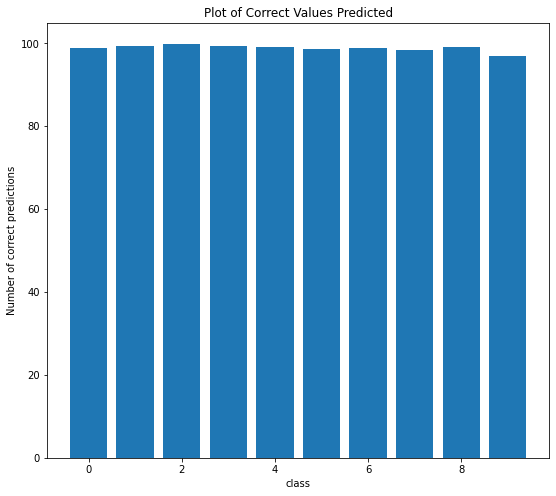

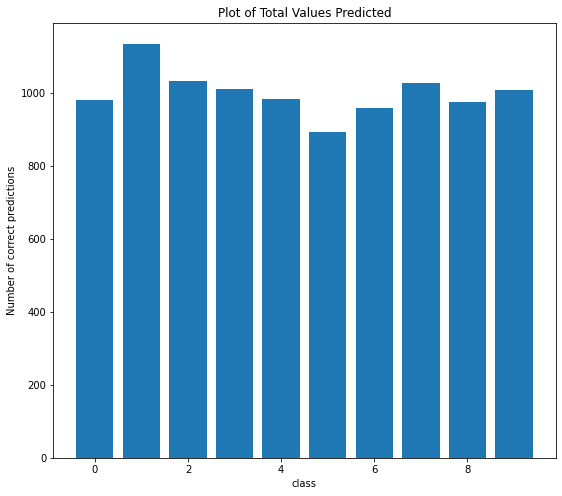

In [69]:
# Plot percentage accuracy of each number prediction
plt.figure(figsize=(9, 8))
plt.title("Plot of Correct Values Predicted")
plt.xlabel("class")
plt.ylabel("Number of correct predictions")
correct_p = np.array(list(correct_pred.values()))
total = np.array(list(total_pred.values()))
plt.bar(x=correct_pred.keys(), height=(correct_p/total)*100)
plt.show()

# Total predictions histogram 
plt.figure(figsize=(9, 8))
plt.title("Plot of Total Values Predicted")
plt.xlabel("class")
plt.ylabel("Number of correct predictions")
plt.bar(x=total_pred.keys(), height=total_pred.values())
plt.show()



From the plots above, the hardest class to predict appears to be the number 9